In [410]:
# Name: Saketh Vangara
# Project: Data Analysis with the YouTube API

In [411]:
from googleapiclient.discovery import build
from dateutil import parser
import pandas as pd
from IPython.display import JSON

# Data Visualization packages
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Natural Language Processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sakethvangara/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sakethvangara/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [412]:
# If forking this repo, generate your own API key from YouTube Data API v3 and replace the current key with it
# Information on how to do this will be provided in the READ.ME
api_key = 'XXXXX'

In [413]:
# Channel Ids list currently includes JJ Olatunji and NFL; you can add more where indicated to see channel statistics
channel_ids = ['UCGmnsW623G1r-Chmo5RB4Yw',
              'UCDVYQ4Zhbm3S2dlz7P1GBDg'
              # Add More Below
              ]

In [414]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(
    api_service_name, api_version, developerKey=api_key)

In [415]:
# Function to get channel statistics
def get_channel_stats(youtube, channel_ids):
    
    """
    Get channel stats
    
    Parameters:
    ------
    youtube: Build object of the Youtube API
    channel_ids: a list of channel IDs
    
    Return(s):
    ------
    Data frame with all channel stats for each channel ID
    
    """
    
    all_data = []
    
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=','.join(channel_ids)
    )
    response = request.execute()

    # loop through items
    for item in response['items']:
        data = {'channelName': item['snippet']['title'],
                'subscribers': item['statistics']['subscriberCount'],
                'views': item['statistics']['viewCount'],
                'totalVideos': item['statistics']['videoCount'],
                'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
        }
        
        all_data.append(data)
        
    return pd.DataFrame(all_data)

# Function to get the video ids --- loops through each item in a playlist for a given youtube build
def get_video_ids(youtube, playlist_id):

    video_ids = []

    request = youtube.playlistItems().list(
        part="snippet, contentDetails",
        playlistId=playlist_id,
        maxResults=50
    )
    response = request.execute()

    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])

    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
            part="snippet, contentDetails",
            playlistId=playlist_id,
            maxResults=50,
            pageToken=next_page_token  # Add pageToken to request the next page
        )
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response.get('nextPageToken')

    return video_ids
    
# Function to get details of videos --- these include various statistics that a user can normally interact with when watching a Youtube video
def get_video_details(youtube, video_ids):

    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
    
    return pd.DataFrame(all_video_info)

In [416]:
channel_stats = get_channel_stats(youtube, channel_ids)

In [417]:
channel_stats

,channelName,subscribers,views,totalVideos,playlistId
0,JJ Olatunji,16400000,4425214509,1405,UUGmnsW623G1r-Chmo5RB4Yw
1,NFL,13700000,11457188187,47215,UUDVYQ4Zhbm3S2dlz7P1GBDg


In [418]:
# Replace the playlist id with another id retrieved from a different channel to view that specific playlist's statistics
# See READ.ME for more details
playlist_id = "PL6_iWvoCGAJmPvZ8Wdr555SHSw3dMc-0m"

In [419]:
# Get video IDs
video_ids = get_video_ids(youtube, playlist_id)

In [420]:
len(video_ids)

181

In [421]:
# Get video details
video_df = get_video_details(youtube, video_ids)
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,yOcgXqVnQFQ,JJ Olatunji,MY REDDIT IS COOKED,KSI - Dirty\nListen Now: https://youtu.be/VoDh...,"[ksi, ksiolajidebt, ksiolajidebthd, jj olatunj...",2024-12-14T17:30:08Z,1405851,78687,None,3010,PT19M15S,hd,false
1,2LuCsIk8Mls,JJ Olatunji,"If You Think This Is KSI, You're Racist",KSI - Thick Of It (feat. Trippie Redd) \nListe...,"[ksi, ksiolajidebt, ksiolajidebthd, jj olatunj...",2024-11-05T18:40:08Z,1410287,76683,None,2969,PT14M52S,hd,false
2,ro__mf9KVM4,JJ Olatunji,DanTDM Finally Responded?,KSI - Thick Of It (feat. Trippie Redd) \nListe...,"[ksi, ksiolajidebt, ksiolajidebthd, jj olatunj...",2024-10-14T19:19:26Z,2375735,117176,None,17111,PT19M21S,hd,false
3,ArtodfKFWso,JJ Olatunji,I GOT ROBBED?,"""Thick Of It"" coming soon https://lnk.to/KSI-...","[ksi, ksiolajidebt, ksiolajidebthd, jj olatunj...",2024-09-05T17:31:59Z,1837067,91434,None,1956,PT13M39S,hd,false
4,jltWRNZ74QI,JJ Olatunji,I HAVE SO MUCH TO SAY ABOUT…,BUY TICKETS AND PPV\nhttps://misfitsboxing.com...,"[ksi, ksiolajidebt, ksiolajidebthd, jj olatunj...",2024-08-23T17:02:39Z,1400780,72834,None,2683,PT20M14S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,vvLNWe4d_C0,JJ Olatunji,I can't react to this fam...,Get Tickets Here: https://www.thenewagetour.co...,"[KSI, I can't, React to this]",2019-03-10T12:55:19Z,9073159,310114,None,9201,PT12M30S,hd,false
175,EBeSqtK6zU4,JJ Olatunji,This Has Gone Too Far...,https://www.reddit.com/r/ksi/\n\nTwitter: http...,"[KSI, Reddit]",2019-01-30T18:38:51Z,5312038,247239,None,12300,PT13M37S,hd,false
176,NEMITTSHxgM,JJ Olatunji,I have a son?,https://www.reddit.com/r/ksi/\n\nTwitter: http...,"[Ksi, i have a son]",2019-01-14T18:09:54Z,8288214,336578,None,17243,PT14M39S,hd,false
177,i-Mv4z_B4pE,JJ Olatunji,SHANE DAWSON IS A...,Buy tour tickets here: http://thenewagetour.co...,[SHANE DAWSON],2019-03-19T21:38:27Z,5040249,182486,None,11228,PT13M32S,hd,false


## Pre-Processing the Data

In [422]:
# Check for NULL values
video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
viewCount         False
likeCount         False
favouriteCount     True
commentCount      False
duration          False
definition        False
caption           False
dtype: bool

In [423]:
# Check data types
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [424]:
# Convert count columns to numeric
numeric_cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

In [425]:
# Publish day in the week
video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parser.parse(x)) 
video_df['pushblishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A")) 

In [426]:
# convert duration to seconds
import isodate
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

In [427]:
video_df[['durationSecs', 'duration']] 

,durationSecs,duration
0,1155.0,PT19M15S
1,892.0,PT14M52S
2,1161.0,PT19M21S
3,819.0,PT13M39S
4,1214.0,PT20M14S
...,...,...
174,750.0,PT12M30S
175,817.0,PT13M37S
176,879.0,PT14M39S
177,812.0,PT13M32S


In [428]:
# Add tag count
video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [429]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,pushblishDayName,durationSecs,tagCount
0,yOcgXqVnQFQ,JJ Olatunji,MY REDDIT IS COOKED,KSI - Dirty\nListen Now: https://youtu.be/VoDh...,"[ksi, ksiolajidebt, ksiolajidebthd, jj olatunj...",2024-12-14 17:30:08+00:00,1405851.0,78687.0,NaN,3010.0,PT19M15S,hd,false,Saturday,1155.0,8
1,2LuCsIk8Mls,JJ Olatunji,"If You Think This Is KSI, You're Racist",KSI - Thick Of It (feat. Trippie Redd) \nListe...,"[ksi, ksiolajidebt, ksiolajidebthd, jj olatunj...",2024-11-05 18:40:08+00:00,1410287.0,76683.0,NaN,2969.0,PT14M52S,hd,false,Tuesday,892.0,8
2,ro__mf9KVM4,JJ Olatunji,DanTDM Finally Responded?,KSI - Thick Of It (feat. Trippie Redd) \nListe...,"[ksi, ksiolajidebt, ksiolajidebthd, jj olatunj...",2024-10-14 19:19:26+00:00,2375735.0,117176.0,NaN,17111.0,PT19M21S,hd,false,Monday,1161.0,8
3,ArtodfKFWso,JJ Olatunji,I GOT ROBBED?,"""Thick Of It"" coming soon https://lnk.to/KSI-...","[ksi, ksiolajidebt, ksiolajidebthd, jj olatunj...",2024-09-05 17:31:59+00:00,1837067.0,91434.0,NaN,1956.0,PT13M39S,hd,false,Thursday,819.0,8
4,jltWRNZ74QI,JJ Olatunji,I HAVE SO MUCH TO SAY ABOUT…,BUY TICKETS AND PPV\nhttps://misfitsboxing.com...,"[ksi, ksiolajidebt, ksiolajidebthd, jj olatunj...",2024-08-23 17:02:39+00:00,1400780.0,72834.0,NaN,2683.0,PT20M14S,hd,false,Friday,1214.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,vvLNWe4d_C0,JJ Olatunji,I can't react to this fam...,Get Tickets Here: https://www.thenewagetour.co...,"[KSI, I can't, React to this]",2019-03-10 12:55:19+00:00,9073159.0,310114.0,NaN,9201.0,PT12M30S,hd,false,Sunday,750.0,3
175,EBeSqtK6zU4,JJ Olatunji,This Has Gone Too Far...,https://www.reddit.com/r/ksi/\n\nTwitter: http...,"[KSI, Reddit]",2019-01-30 18:38:51+00:00,5312038.0,247239.0,NaN,12300.0,PT13M37S,hd,false,Wednesday,817.0,2
176,NEMITTSHxgM,JJ Olatunji,I have a son?,https://www.reddit.com/r/ksi/\n\nTwitter: http...,"[Ksi, i have a son]",2019-01-14 18:09:54+00:00,8288214.0,336578.0,NaN,17243.0,PT14M39S,hd,false,Monday,879.0,2
177,i-Mv4z_B4pE,JJ Olatunji,SHANE DAWSON IS A...,Buy tour tickets here: http://thenewagetour.co...,[SHANE DAWSON],2019-03-19 21:38:27+00:00,5040249.0,182486.0,NaN,11228.0,PT13M32S,hd,false,Tuesday,812.0,1


## EDA

### Best Performing videos

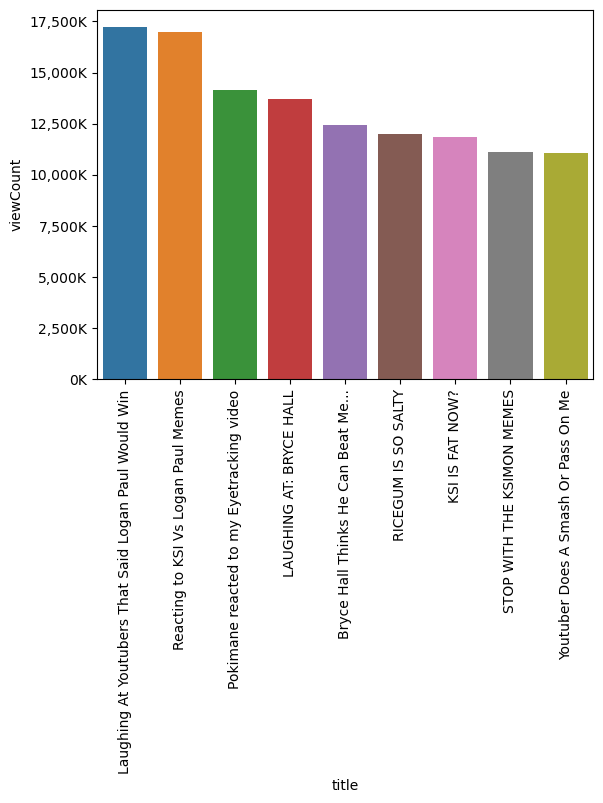

In [430]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=False)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

### Worst Performing videos

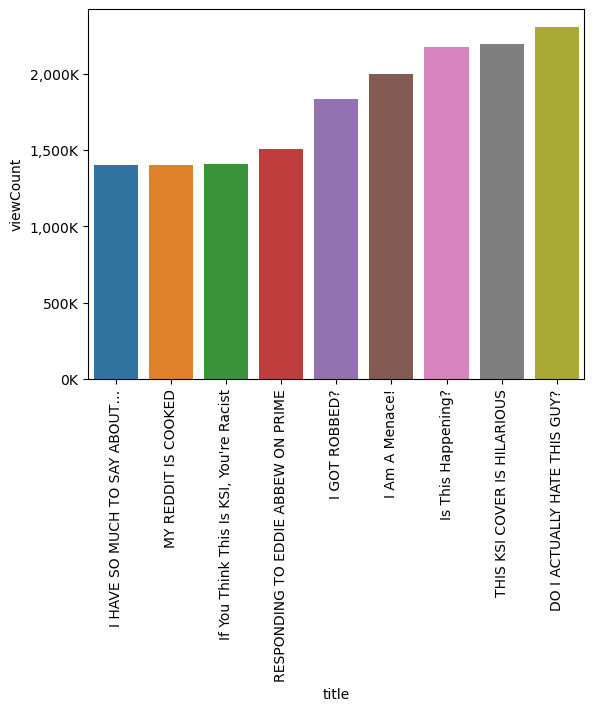

In [431]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=True)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

### View Distribution per Video

<Axes: xlabel='channelTitle', ylabel='viewCount'>

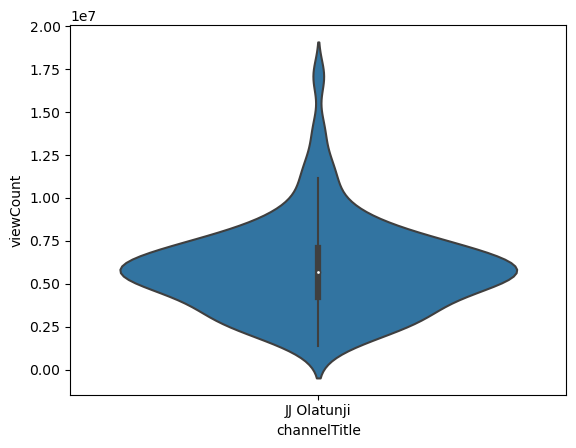

In [432]:
sns.violinplot(x = video_df['channelTitle'], y = video_df['viewCount'])

### Views vs. Comments and Likes Distributions

<Axes: xlabel='likeCount', ylabel='viewCount'>

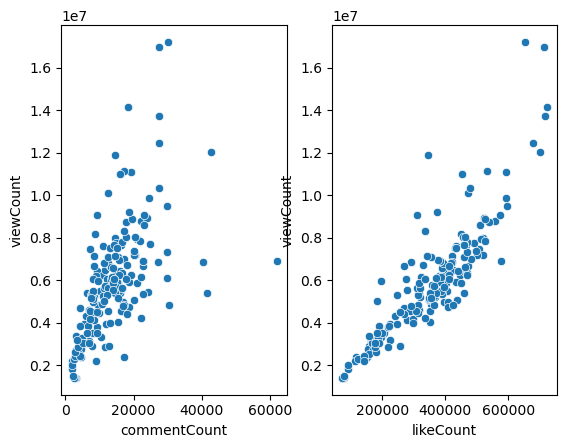

In [433]:
fig, ax = plt.subplots(1,2)
sns.scatterplot(data = video_df, x = 'commentCount', y = 'viewCount', ax = ax[0])
sns.scatterplot(data = video_df, x = 'likeCount', y = 'viewCount', ax = ax[1])

### Video Duration Statistics

<Axes: xlabel='durationSecs', ylabel='Count'>

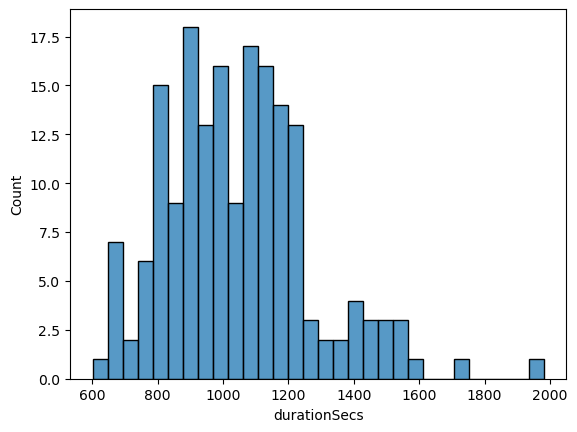

In [434]:
sns.histplot(data = video_df, x = 'durationSecs', bins=30)

### WordCloud for Video Titles

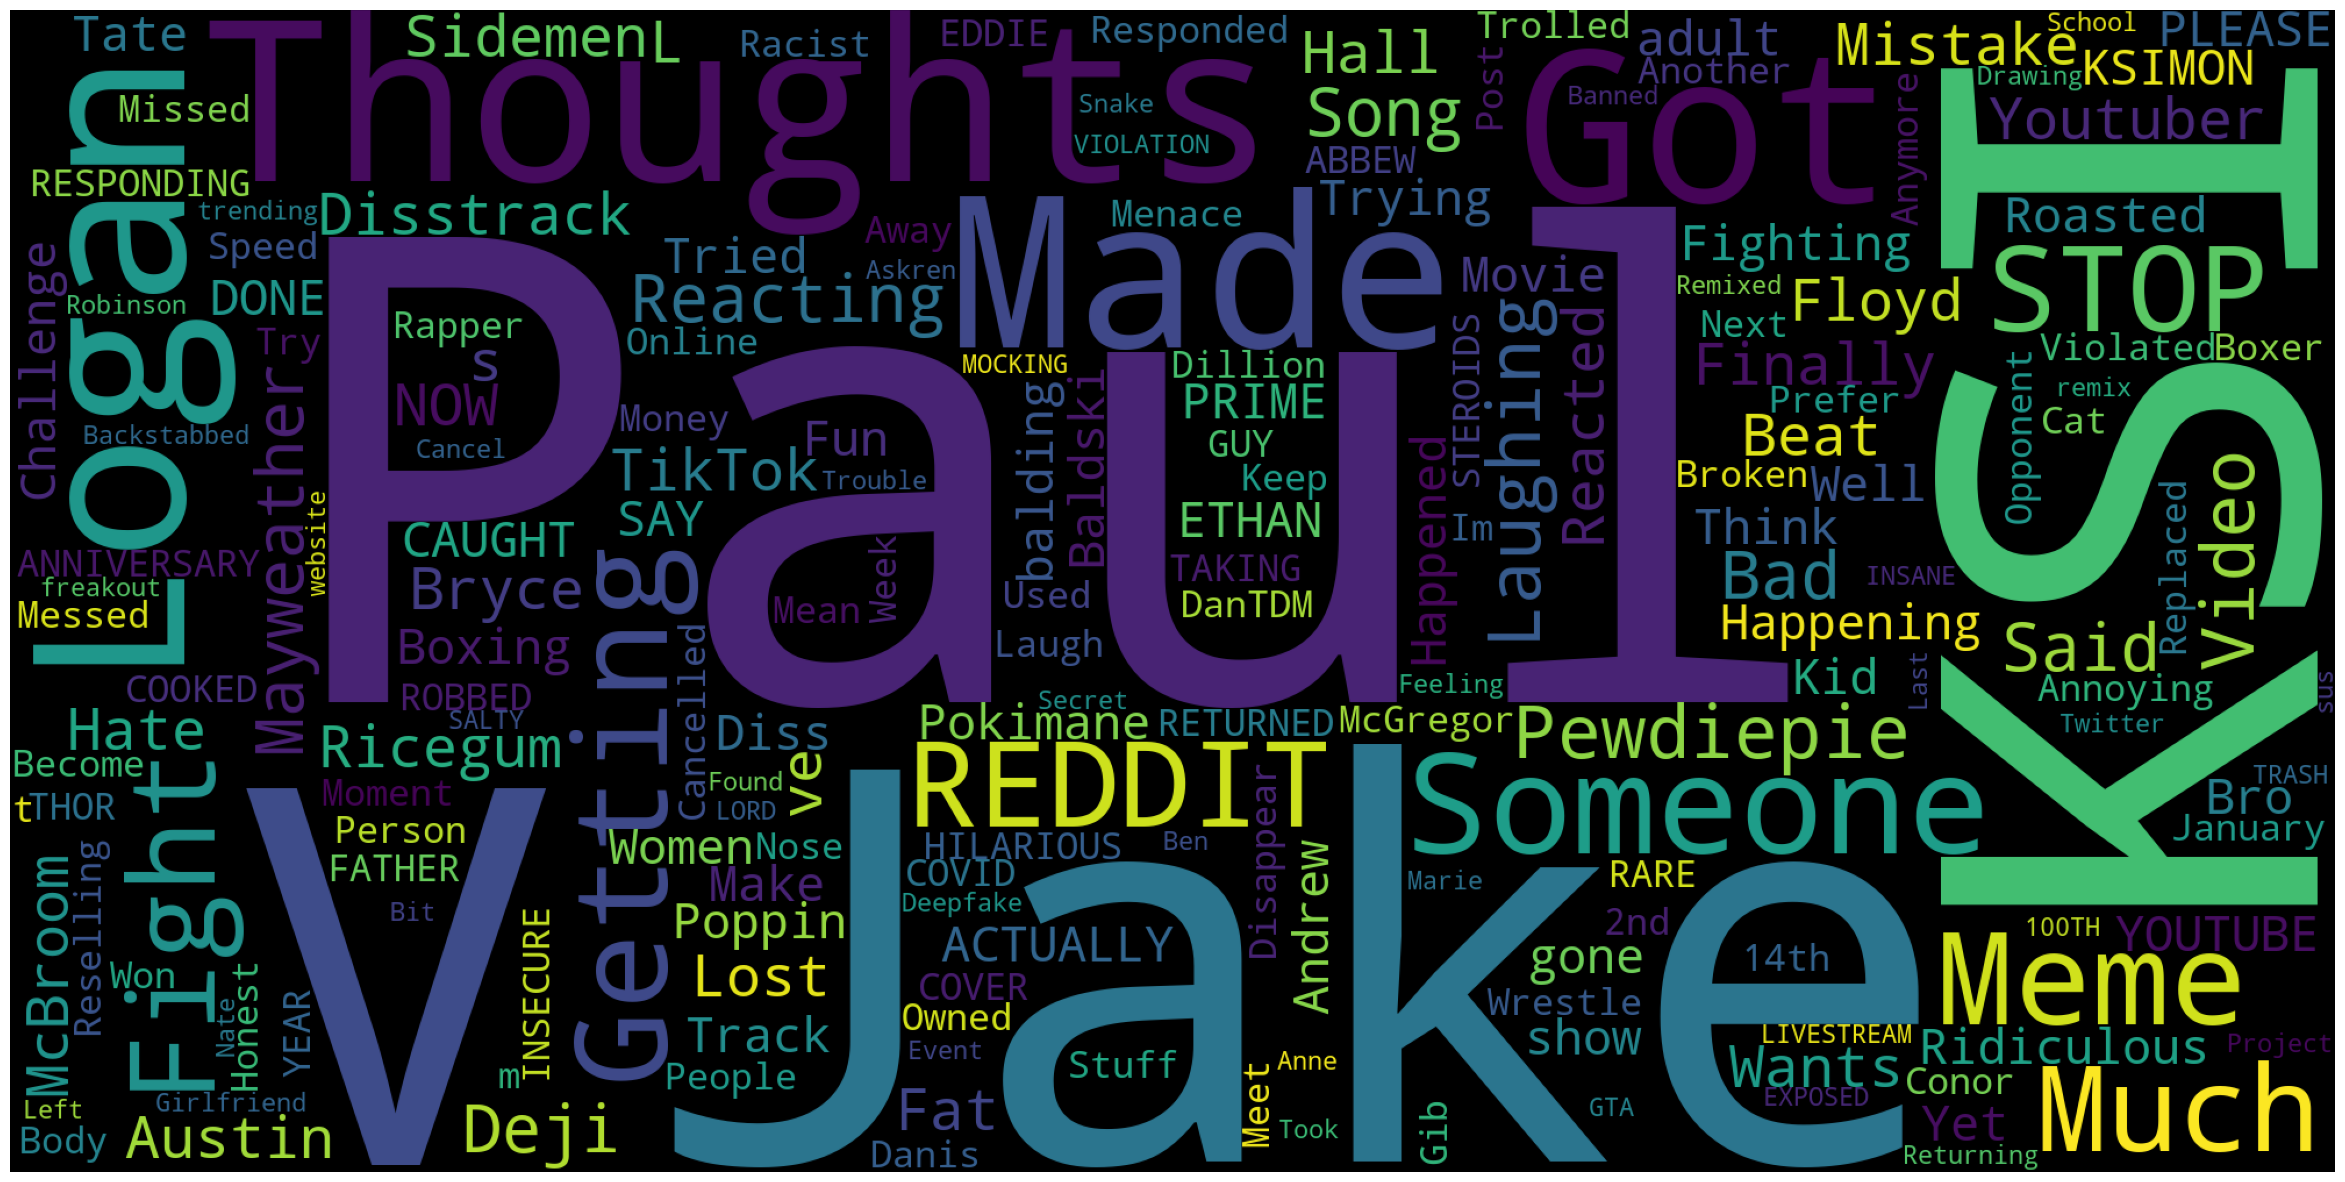

In [435]:
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

### Upload Schedule

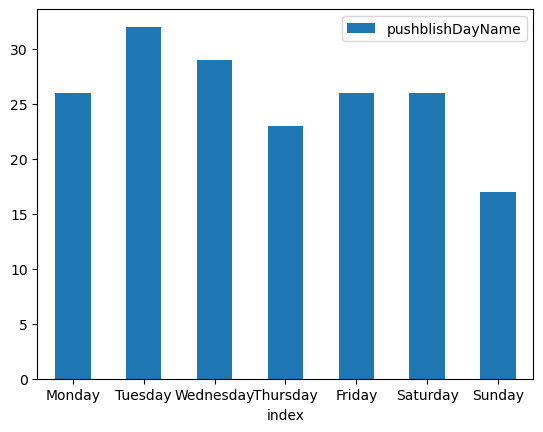

In [436]:
day_df = pd.DataFrame(video_df['pushblishDayName'].value_counts())
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.reset_index().plot.bar(x='index', y='pushblishDayName', rot=0)